# Spatial Interpolation with ESI on Gridded Data

Spatialize supports two formats formats for input data. This document provides an overview on the basic implementation for gridded data.

In [1]:
# === Libraries ===

# Importar ESI desde repositorio, no desde instalación python, borrar antes de publicar!!
import sys
sys.path.append('../')
import import_helper

import numpy as np
from matplotlib import pyplot as plt

import spatialize.gs.esi.aggfunction as af
from spatialize.gs.esi import esi_griddata
from sklearn.metrics import mean_absolute_error


## Gridded data

The **`esi_griddata()`** function is designed to produce estimations over a dense mesh-grid (i.e. a tuple or array of regular arrays).
In the 2-D scenario, the shape of this array is $(2 \times N_x \times N_y)$, while in the 3-D scenario it is of shape $(3 \times N_x \times N_y \times N_z)$, where $N_x$, $N_y$, and $N_z$ are the number of points or grid cells in the X, Y and Z axes, respectively.

Therefore, for a D-dimensional scenario, we would produce estimates over an array of size $(D \times N_1 \times \cdots \times N_D)$.

The `mgrid()` function from the numpy library can be used to generate a grid of such characteristics, as follows:

In [2]:
# 2-D grid generation: 100x150 grid
x_max, y_max = 100,150
xi_2d = np.mgrid[1:x_max:x_max*1j, 1:y_max:y_max*1j]

# 3-D grid generation: 100x150x30 grid
z_max = 20
xi_3d = np.mgrid[1:x_max:x_max*1j, 1:y_max:y_max*1j, 1:z_max:z_max*1j]

We can corroborate the shape of these grids is $(D \times N_1 \times \cdots \times N_D)$:

In [3]:
xi_2d.shape

(2, 100, 150)

In [4]:
xi_3d.shape

(3, 100, 150, 20)

> Note: Currently suported local interpolator-partition process combinations for gridded data are:
- 'idw' as local interpolator and 'mondrian' as partition process supports up to 3-dimensional data
- 'idw' as local interpolator and 'voronoi' as partition process supports 2-dimensional data
- 'kriging' as local interpolator and 'mondrian' as partition process supports 2-dimensional data

## Producing ESI Estimates Over the Grid
Now, we will produce ESI estimates over both grids.

### Samples
For this example, we will employ synthetic sample data.

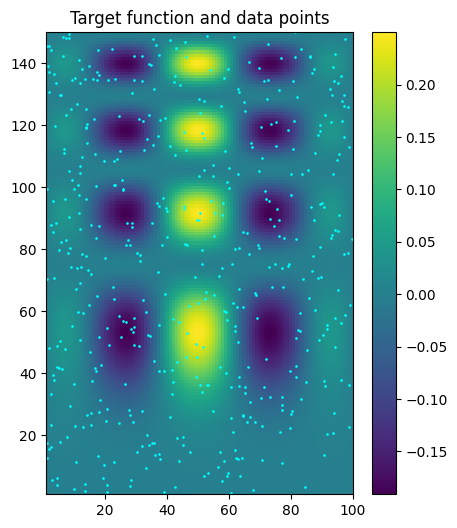

In [5]:
# === 2-D Scenario ===

def func(x, y):  # a kind of "cubic" function
    x = x/x_max
    y = y/y_max
    return x * (1 - x) * np.cos(4 * np.pi * x) * np.sin(4 * np.pi * y ** 2) ** 2 

# random points to sample original function and generate 'points' and 'values' inputs
np.random.seed(42)
points_2d = np.random.random((500, 2)) * [x_max, y_max]
values_2d = func(points_2d[:, 0], points_2d[:, 1])

# plot with original function and generated points
fig = plt.figure(figsize=(5, 6))
plt.scatter(points_2d[:, 0], points_2d[:, 1], s=0.8, color='cyan')
plot = plt.imshow(func(xi_2d[0], xi_2d[1]).T, origin='lower', cmap='viridis', extent=[1, x_max, 1, y_max])
plt.colorbar(plot)
plt.title('Target function and data points')
plt.show()


In [6]:
# === 3-D Scenario === 

def func_3d(x, y, z):  # a kind of "cubic" function in 3D
    x = x/x_max
    y = y/y_max
    z = z/z_max

    return (x * (1 - x) * np.cos(4 * np.pi * x) * 
            np.sin(4 * np.pi * y ** 2) ** 2 * 
            np.cos(4 * np.pi * z))

# random points to sample original function and generate 'points' and 'values' inputs
np.random.seed(42)
points_3d = np.random.random((500, 3)) * [x_max, y_max, z_max]
values_3d = func_3d(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2])

### Producing Estimates

Next, we employ the ``esi_griddata`` function to produce the estimates. Here, we will use inverse distance weighting (IDW) as local interpolator.

In [7]:
result_2d = esi_griddata(points_2d, values_2d, xi_2d,
                         local_interpolator="idw",
                         p_process="mondrian",
                         exponent=1.0,
                         n_partitions=300, alpha=0.985,
                         agg_function=af.mean
                         )


esi_est_2d = result_2d.estimation()

finished 100% of 300 iterations ... 

done (elapsed time:  4s)


We can quickly visualize the results with the `quick_plot()` method:

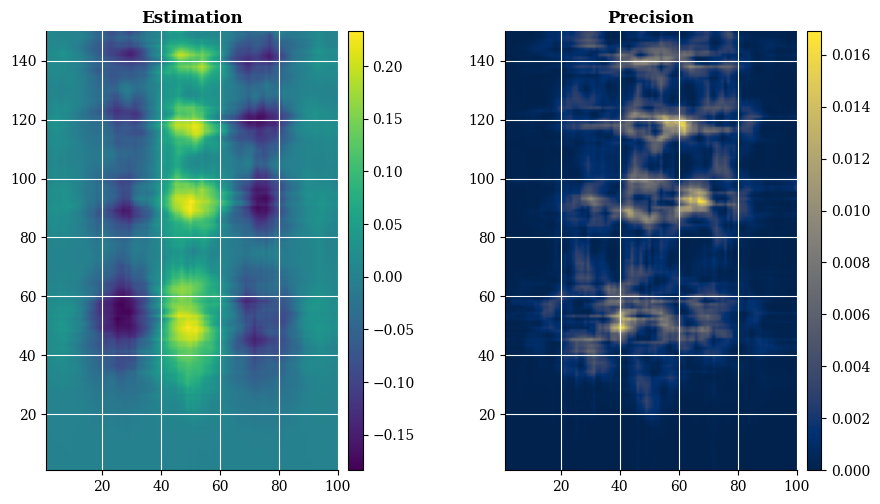

In [8]:
result_2d.quick_plot(theme='publication', dpi = 100)
plt.show()

Since we are using synthetic data, we can calculate performance metrics between the reference values and the estimated values:

In [9]:
print(f"MAE = {mean_absolute_error(func(xi_2d[0], xi_2d[1]), esi_est_2d):.4f}")

MAE = 0.0154


Now, we will produce estimates for the 3D scenario.

In [10]:
result_3d = esi_griddata(points_3d, values_3d, xi_3d,
                      local_interpolator="idw",
                      p_process="mondrian",
                      data_cond=False,
                      exponent=1.0,
                      n_partitions=100,
                      alpha=0.8,
                      agg_function=af.mean
                      )

esi_est_3d = result_3d.estimation()


finished 100% of 100 iterations ... 

done (elapsed time: 34s)


> Note: The ``quick_plot()`` method is not supported for 3D data.

Finally, we calculate the mean absolute error:

In [11]:
print(f"MAE = {mean_absolute_error(func_3d(xi_3d[0], xi_3d[1], xi_3d[2]).flatten(), esi_est_3d.flatten()):.4f}")

MAE = 0.0289
